##Optimization by Annealing

In [ ]:
# @title
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:

  IN_COLAB = False

# Let's install with dimod and neal
if IN_COLAB:
    !pip install dwave-ocean-sdk

In [ ]:
# @title
!pip install dwave-neal

In [ ]:
# @title
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx

## Setting up the Problem class

In [ ]:
np.set_printoptions(threshold=np.inf)
class Problem:
    def __init__(self, M, N, lam, d, in_angles, out_angles, constraints=None):
        self.M = M
        self.N = N
        self.lam = lam
        self.d = d
        self.theta_in = in_angles[0]
        self.phi_in = in_angles[1]
        self.theta_out = out_angles[0]
        self.phi_out = out_angles[1]
        self.k = 2 * np.pi / lam
        self.Q = None  # will be computed when needed
        self.constraints = constraints

    def phase(self, m, n, theta_out, phi_out):
        part1 = -m * np.sin(theta_out) * np.cos(phi_out)
        part2 = -n * np.sin(theta_out) * np.sin(phi_out)
        part3 = m * np.sin(self.theta_in) * np.cos(self.phi_in)
        part4 = n * np.sin(self.theta_in) * np.sin(self.phi_in)
        return self.k * self.d * (part1 + part2 + part3 + part4)

    def compute_Q(self, theta_out = None, theta_in = None):

      if theta_out is None:
        theta_out = self.theta_out
      if theta_in is not None:
        theta_in = self.theta_in

      Q = np.zeros((self.M * self.N, self.M * self.N))
      for row in range(self.M * self.N):
          m1, n1 = divmod(row, self.M)
          for col in range(row):
              m2, n2 = divmod(col, self.M)
              phase_diff = self.phase(m1, n1, theta_out, phi_out) - self.phase(m2, n2, theta_out, phi_out)
              Q[row, col] = np.cos(phase_diff)
          # Q[row, row] = 0
      self.Q = Q

      return Q

    def array_factor(self,  w_arr, Q = None):
      if Q is None:
        if self.Q is None:
            self.compute_Q()
        Q = self.Q
      arr_fac = (1 / (self.M * self.N) ** 2) * (1*M*N + w_arr.T @ Q @ w_arr)
      return arr_fac


    def check_constraints(self, w_arr):
        if self.constraints is None:
            return "No constraints"

        checks = []
        for constraint in self.constraints:
          theta_o = constraint[0]
          phi_o = constraint[1]
          threshold = constraint[2]

          Q_i = self.compute_Q(theta_o, phi_o)
          arr_fac_i = self.array_factor(w_arr, Q = Q_i)

          if arr_fac_i <= threshold:
            checks.append(True)
          else:
            checks.append(False)

        return checks


    def sort_with_partner(self, arr1, arr2):
      arr1 = arr1.flatten()  # Need to assign the result
      arr2 = arr2.flatten()
      n = len(arr1)

      # Simple bubble sort implementation
      for k in range(n):
          for l in range(0, n-k-1):
              if arr1[l] > arr1[l+1]:
                  arr1[l], arr1[l+1] = arr1[l+1], arr1[l]
                  arr2[l], arr2[l+1] = arr2[l+1], arr2[l]

      return arr1, arr2

    def ssn_soln(self):
    # Calculate phases for all elements
      phase_list = np.array([
          self.phase(m, n, self.theta_out, self.phi_out) % (2*np.pi)
          for i in range(self.M * self.N)
          for m, n in [divmod(i, self.M)]
      ])

      # Create index array to track original positions
      original_indices = np.arange(self.M * self.N)

      # Sort phases while keeping track of original indices
      sorted_phases, sorted_indices = self.sort_with_partner(
          phase_list.copy(),
          original_indices.copy()
      )

      # Initialize tracking variables
      w_arr_max = np.zeros(self.M * self.N)
      af_max = 0

      # Main OPA algorithm
      for i in range(self.M * self.N):
          delta_i = sorted_phases[i]
          delta_i_lim = (delta_i + np.pi) % (2*np.pi)

          # Temporary weight array (in sorted order)
          w_temp = np.zeros(self.M * self.N)

          # Assign weights based on phase
          for j in range(self.M * self.N):
              phase_j = sorted_phases[j]

              if delta_i < delta_i_lim:
                  # Normal case - single interval
                  if delta_i <= phase_j < delta_i_lim:
                      w_temp[j] = +1
                  else:
                      w_temp[j] = -1
              else:
                  # Wrapped case - two intervals
                  if phase_j >= delta_i or phase_j < delta_i_lim:
                      w_temp[j] = +1
                  else:
                      w_temp[j] = -1

          # Reorder weights back to original order for array factor calculation
          w_original_order = np.zeros_like(w_temp)
          w_original_order[sorted_indices] = w_temp  # Reconstruct original ordering

          # Calculate array factor
          af_cur = self.array_factor(w_original_order)

          # Update maximum if improved
          if af_cur > af_max:
              af_max = af_cur
              w_arr_max = w_original_order.copy()

      return af_max,w_arr_max



def cost(x,Q):
    return x.T @ Q @ x





Initializing the QUBO problem with parameters

In [ ]:
constraints = [(np.pi/6, np.pi/6, 0.1)]


M = 4
N = 4
lam = 1e-3
d = lam / 1
theta_in = np.pi / 5
phi_in = np.pi / 3
theta_out = np.pi / 7
phi_out = np.pi / 4

## constrain parameters
theta_in2 = np.pi / 6
phi_in2 = np.pi / 3.5
theta_out2 = np.pi / 7
phi_out2 = np.pi / 3

K = 5

prob = Problem(M, N, lam, d, in_angles=(theta_in, phi_in), out_angles=(theta_out, phi_out), constraints=None)
prob.constraints =constraints

prob2 = Problem(M,N,lam,d,in_angles=(theta_in2,phi_in2),out_angles=(theta_out2,phi_out2),constraints=None)

w_arr = np.ones((M * N, 1), dtype=float)

Q = prob.compute_Q()
Q2 = prob2.compute_Q()

Q_input1 = (Q + Q.T - 2 *(Q2 +Q2.T))

# # TRANSFORMING TO (0,1)

cQ = np.sum(Q_input1)

prod = np.ones((1,M*N)) @ Q_input1
q = np.zeros_like(Q_input1)

for i in range(M*N):
    q[i][i] = prod[0][i]

Q_input = 4*Q_input1 - 4*q

# print(Q_input)


af_max, w_array_max = prob.ssn_soln()
print(af_max)
print(w_array_max)

print(cost(w_array_max, Q+Q.T))

0.3244256907406169
[-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.]
134.10595365919588


---
###Brute Force algorithm to solve the problem

In [ ]:
# BRUTE FORCE

from itertools import product
  # total length = M * N

cost_optimal = 0
cur_cost =0
for x in product([-1, 1], repeat=M * N):
    # print(np.array(x))
    cur_cost = cost(np.array(x),Q_input1)
    if(cur_cost>cost_optimal):
        cost_optimal = cur_cost
        w_array_optimal = x

print(cost_optimal)
print(w_array_optimal)
print(w_array_max.T)
print(cost(w_array_max,Q_input1))




88.73482598981592
(-1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1)
[-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.]
44.95280431333467


### Plotting functions for Annealer

In [ ]:
#This is the code from the lecture notebooks to create the graphs of energy levels obtained, we use this to get a better understanding of the probabilities and energies
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    # print("minimum energy:", min(energies))


def plot_energies(results, title=None):
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    # print("minimum energy:", min(energies))

### Defining quadratic model to input to D-Wave Annealers  

In [ ]:
#dimod package converts qubo model directly to ising models readable by annealers
model = dimod.BinaryQuadraticModel.from_qubo(-Q_input)


We can check the functioning of the model in Simulated Annealing before using the DWave QPU

In [ ]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model, num_reads=100,num_sweeps=100000,num_sweeps_per_beta = 1)


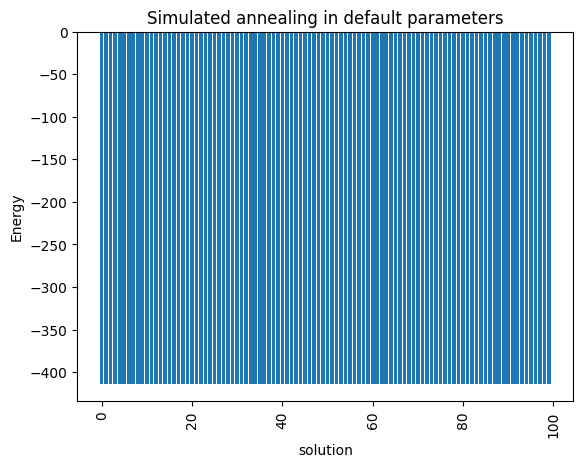

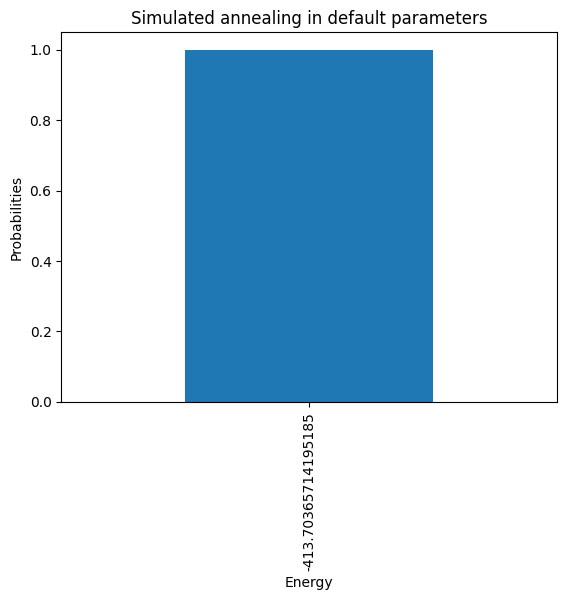

{'beta_range': [np.float64(0.0077798864615699695), np.float64(5184960683398422.0)], 'beta_schedule_type': 'geometric', 'timing': {'preprocessing_ns': 7237945, 'sampling_ns': 1391172328, 'postprocessing_ns': 407988}}


In [ ]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')
print(simAnnSamples.info)

In [ ]:
sample = simAnnSamples.first.sample
sim_arr = np.array([sample[i] for i in sorted(sample)])
sim_arr = sim_arr*2 - np.ones_like(sim_arr)
print(sim_arr)
# print(w_array_optimal)
print(cost(sim_arr,Q_input1),cost(np.array(w_array_optimal),Q_input1))

[ 1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1]
88.73482598981592 88.73482598981592


Simulated annealing is slow for large problems.
---
## Now let's solve this using Quantum Annealing!







In [ ]:
# Let's setup the D-Wave connection
if IN_COLAB:
    !dwave setup

Optionally install non-open-source packages and configure your environment.

Do you want to select non-open-source packages to install (y/n)? [y]: n

Creating the D-Wave configuration file.

Using the simplified configuration flow.
Try 'dwave config create --full' for more options.

Updating existing configuration file: /root/.config/dwave/dwave.conf
Available profiles: defaults
Updating existing profile: defaults
Solver API token [UcZ6-5eed51bb549884b32a31eb22d284334809311d1b]: UcZ6-5eed51bb549884b32a31eb22d284334809311d1b
Configuration saved.


In [ ]:
!dwave ping

Using endpoint: https://cloud.dwavesys.com/sapi/
Using region: na-west-1
Using solver: Advantage_system4.1
Submitted problem ID: b1da2a1a-81da-4b31-a41a-8ca50136545c

Wall clock time:
 * Solver definition fetch: 634.735 ms
 * Problem submit and results fetch: 701.973 ms
 * Total: 1336.709 ms

QPU timing:
 * post_processing_overhead_time = 1.0 us
 * qpu_access_overhead_time = 225.26 us
 * qpu_access_time = 15859.74 us
 * qpu_anneal_time_per_sample = 20.0 us
 * qpu_delay_time_per_sample = 20.58 us
 * qpu_programming_time = 15782.76 us
 * qpu_readout_time_per_sample = 36.4 us
 * qpu_sampling_time = 76.98 us
 * total_post_processing_time = 1.0 us


In [ ]:
import dwave_networkx as dnx
from dwave.system import (DWaveSampler, EmbeddingComposite,
                          FixedEmbeddingComposite)
from pprint import pprint

In [ ]:
# Graph corresponding to D-Wave 2000Q
qpu = DWaveSampler()
qpu_edges = qpu.edgelist
qpu_nodes = qpu.nodelist
pprint(dir(qpu))
if qpu.solver.id == "DW_2000Q_6":
    print(qpu.solver.id)
    X = dnx.chimera_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_chimera(X, node_size=1)
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))
elif qpu.solver.id == "Advantage_system1.1":
    print(qpu.solver.id)
    X = dnx.pegasus_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_pegasus(X, node_size=1)
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))
print(len(qpu_nodes),len(qpu_edges))

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_edgelist',
 '_get_solver',
 '_nodelist',
 '_solver_penalty',
 'adjacency',
 'client',
 'close',
 'edgelist',
 'failover',
 'nodelist',
 'parameters',
 'properties',
 'remove_unknown_kwargs',
 'retry_interval',
 'sample',
 'sample_ising',
 'sample_qubo',
 'solver',
 'structure',
 'to_networkx_graph',
 'trigger_failover',
 'valid_bqm_graph',
 'validate_anneal_schedule',
 'warnings_default']
5627 40279


In [ ]:
print(qpu.properties["annealing_time_range"])
qpu.properties["default_annealing_time"]

[0.5, 2000.0]


20.0

### Annealing with the D-Wave QPU and comparing plots:

In [ ]:
DWavesampler = EmbeddingComposite(DWaveSampler())

initial = w_array_max
# Define a reverse annealing schedule
# (time in μs, anneal fraction s)
schedule = [
    (0.0, 1.0),         # Start at classical
    (5.0, 0.45),        # Reverse to s=0.45
    (35.0, 0.45),       # Pause for 30 μs
    (40.0, 1.0)         # Anneal forward
]

DWaveSamples = DWavesampler.sample(bqm=model, initial_state = {i: initial[i] for i in range(len(initial))},
                                   anneal_schedule = schedule, num_reads=1000, return_embedding=True, reinitialize_state=True)

In [ ]:
print(DWaveSamples.info)

{'timing': {'qpu_sampling_time': 130940.0, 'qpu_anneal_time_per_sample': 40.0, 'qpu_readout_time_per_sample': 74.82, 'qpu_access_time': 146701.76, 'qpu_access_overhead_time': 1392.24, 'qpu_programming_time': 15761.76, 'qpu_delay_time_per_sample': 16.12, 'post_processing_overhead_time': 1.0, 'total_post_processing_time': 1.0}, 'problem_id': '94dfc97a-3465-43c0-a9fb-16f44dbccc66', 'embedding_context': {'embedding': {1: (3799, 815, 814), 0: (3964, 920), 2: (3709, 845, 844), 3: (3994, 829, 830), 4: (784, 3859), 5: (3904, 3903), 6: (4039, 859, 860), 7: (3918, 3919), 8: (874, 875), 9: (905, 3979), 10: (890, 889), 11: (755, 3889), 12: (3813, 964, 3814), 13: (770, 3844), 14: (950, 3828, 3829), 15: (3874, 799)}, 'chain_break_method': 'majority_vote', 'embedding_parameters': {}, 'chain_strength': 15.413297869157532}}


In [ ]:
embedding = DWaveSamples.info['embedding_context']['embedding']
if qpu.solver.id == "DW_2000Q_6":
  dnx.draw_chimera_embedding(X, embedding, node_size=2)
elif qpu.solver.id == "Advantage_system1.1":
  dnx.draw_pegasus_embedding(X, embedding, node_size=2)

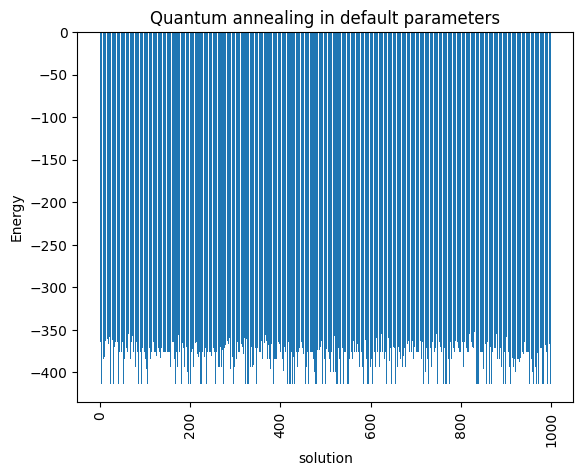

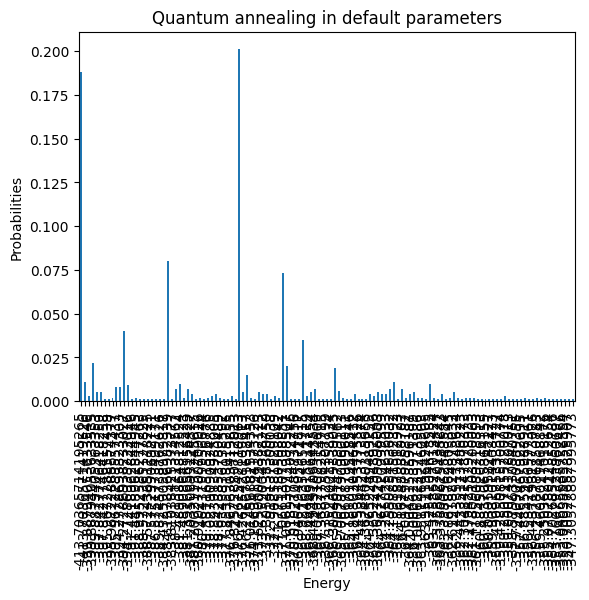

In [ ]:
plot_enumerate(DWaveSamples, title='Quantum annealing in default parameters')
plot_energies(DWaveSamples, title='Quantum annealing in default parameters')

In [ ]:
dsample = DWaveSamples.first.sample
arr = np.array([dsample[i] for i in sorted(dsample)])
arr = np.ones_like(arr) - arr*2
print(arr)
print(sim_arr)
print('Simulated Annealing Result:',cost(sim_arr,Q_input1))
print('Quantum Annealing Result:',cost(arr,Q_input1))
# print(w_array_optimal)
# print(cost(arr,Q_input1),cost(np.array(w_array_optimal),Q_input1))

print(prob.array_factor(arr,(Q2+Q2.T + np.eye(M*N))))
constraint_results = prob.check_constraints(arr)
print("\n\n\nConstraint satisfaction:")
if constraint_results == "No constraints":
    print("No constraints defined.")
else:
    for i, result in enumerate(constraint_results):
        print(f"  Constraint {i+1}: {'✅ Passed' if result else '❌ Failed'}")

[ 1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1]
[ 1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1]
Simulated Annealing Result: 88.73482598981592
Quantum Annealing Result: 88.73482598981592
0.07982408976047989



Constraint satisfaction:
  Constraint 1: ✅ Passed
